# **Task One : Build a Random Forest Classifier :**

  * **Description**: Implement a Random Forest model forclassification on a complex dataset.

**Objective**:
  * Train a Random Forest model and tune hyperparameters (e.g. number of trees, max depth).
  * Evauate the model using cross-validation and classification metrics (precision, recall, F1-score).
  * Perform feature importance analysis to identify the most importanct features in the dataset.



## **0.1 Connect to google colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Codveda Technologies')

## **0.2 Setup the device**

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **0.3 Import Dependencies**

In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 25.2 MB/s eta 0:00:00


In [5]:
import os, joblib, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from rich.console import Console
from rich.table import Table
console = Console()

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

from pathlib import Path
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance
import optuna

## **1.1 Load Preprocessed Data**

In [6]:
def load_preprocessed(filename: str) -> dict:
    """
    Load preprocessed dataset dictionary from a pickle file.

    Parameters
    ----------
    filename : str
        Path to the saved pickle file.

    Returns
    -------
    dict
        Dictionary containing train/val/test splits.
    """
    filepath = Path(filename)
    if not filepath.exists():
        raise FileNotFoundError(f"❌ File not found: {filepath.resolve()}")

    with open(filepath, "rb") as f:
        data = pickle.load(f)

    print(f"✅ Preprocessed dataset loaded from {filepath.resolve()}")
    return data

In [7]:
loaded_splits = load_preprocessed("/content/drive/MyDrive/Codveda Technologies/data/preprocessed/preprocessed_churn_80.pkl")
X_train, y_train = loaded_splits["X_train"], loaded_splits["y_train"]
X_val, y_val     = loaded_splits["X_val"], loaded_splits["y_val"]
X_test, y_test   = loaded_splits["X_test"], loaded_splits["y_test"]

console.print(f"[cyan]Train Size: {X_train.shape[0]} | Validation Size: {X_val.shape[0]} | Test Size: {X_test.shape[0]}")

✅ Preprocessed dataset loaded from /content/drive/MyDrive/Codveda Technologies/data/preprocessed/preprocessed_churn_80.pkl


Train Size: 1866 | Validation Size: 533 | Test Size: 267

## **1.2 Cross-Validation Helper**

In [8]:
def cv_report(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc"
    }
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False)
    row = {m: (scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()) for m in scoring.keys()}

    table = Table(title=f"📊 {model.__class__.__name__} CV ({cv_splits}-fold)", show_lines=True)
    table.add_column("Metric", style="cyan", justify="center")
    table.add_column("Mean", justify="center")
    table.add_column("Std", justify="center")
    for m,(mu,sig) in row.items():
        table.add_row(m.upper(), f"{mu:.3f}", f"{sig:.3f}")
    console.print(table)
    return row


## **1.3 Hyperparameter Tuning**

In [9]:
USE_OPTUNA = True
best_model = None
best_params = None

def tune_with_randomized_search():
    param_dist = {
        "n_estimators": [200, 300, 500, 700, 1000],
        "max_depth": [None, 6, 8, 10, 12, 16, 20],
        "max_features": ["sqrt", "log2", 0.5, 0.7, 1.0],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "class_weight": [None, "balanced"]
    }
    base = RandomForestClassifier(random_state=42, n_jobs=-1)
    rs = RandomizedSearchCV(
        estimator=base, param_distributions=param_dist,
        n_iter=40, scoring="roc_auc", n_jobs=-1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        random_state=42, verbose=0
    )
    rs.fit(X_train, y_train)
    return rs.best_estimator_, rs.best_params_, rs.best_score_

try:
    if USE_OPTUNA:
        console.rule("[bold yellow]Hyperparameter Tuning with Optuna")

        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=100),
                "max_depth": trial.suggest_int("max_depth", 6, 24) if trial.suggest_categorical("use_max_depth",[True, False]) else None,
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, 0.7, 1.0]),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
                "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
                "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
            }
            model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_validate(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
            return scores["test_score"].mean()

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=40, show_progress_bar=False)

        best_params = study.best_trial.params
        # Convert the optional depth flag
        if not best_params.pop("use_max_depth"):
            best_params["max_depth"] = None

        best_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
        best_model.fit(X_train, y_train)
        console.print(f"[green]✅ Optuna Best Params:[/green] {best_params}")
    else:
        raise ImportError("Optuna disabled")
except Exception as e:
    console.print(f"[yellow]⚠️ Optuna not available or failed ({e}). Falling back to RandomizedSearchCV.[/yellow]")
    best_model, best_params, _ = tune_with_randomized_search()
    console.print(f"[green]✅ RandomizedSearchCV Best Params:[/green] {best_params}")

──────────────────────────────────────── Hyperparameter Tuning with Optuna ────────────────────────────────────────

[I 2025-08-28 23:06:27,729] A new study created in memory with name: no-name-dee3a052-842d-4626-9b40-eaf2455c0717
[I 2025-08-28 23:06:46,816] Trial 0 finished with value: 0.9169483761333291 and parameters: {'n_estimators': 500, 'use_max_depth': False, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.9169483761333291.
[I 2025-08-28 23:06:59,051] Trial 1 finished with value: 0.9071863884403069 and parameters: {'n_estimators': 500, 'use_max_depth': False, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.9169483761333291.
[I 2025-08-28 23:07:34,756] Trial 2 finished with value: 0.9165466578005763 and parameters: {'n_estimators': 500, 'use_max_depth': True, 'max_depth': 16, 'max_features': 1.0, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with va

✅ Optuna Best Params: {'n_estimators': 700, 'max_features': 0.5, 'min_samples_split': 4, 'min_samples_leaf': 3, 
'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None}

## **1.4 Final Evaluation on Test Set**

In [10]:
def evaluate_on_split(model, X, y, split_name="Test"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred),
    }
    if y_proba is not None:
        metrics["AUC"] = roc_auc_score(y, y_proba)

    # Rich table
    table = Table(title=f"📋 {split_name} Performance", show_lines=True)
    table.add_column("Metric", style="cyan", justify="center")
    table.add_column("Score", justify="center")
    for k,v in metrics.items():
        table.add_row(k, f"{v:.3f}")
    console.print(table)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual:0","Actual:1"], columns=["Pred:0","Pred:1"])
    fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale="Viridis",
                       title=f"Confusion Matrix — {split_name}", template="plotly_dark")
    fig_cm.update_layout(title_x=0.5)
    fig_cm.show()

    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y, y_proba)
        fig_roc = go.Figure()
        fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name=f"ROC (AUC={metrics['AUC']:.3f})"))
        fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode="lines", name="Random", line=dict(dash="dash")))
        fig_roc.update_layout(template="plotly_dark", title=f"ROC Curve — {split_name}", title_x=0.5,
                              xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
        fig_roc.show()

        # Precision-Recall Curve
        prec, rec, _ = precision_recall_curve(y, y_proba)
        fig_pr = go.Figure()
        fig_pr.add_trace(go.Scatter(x=rec, y=prec, mode="lines", name="PR Curve"))
        fig_pr.update_layout(template="plotly_dark", title=f"Precision-Recall — {split_name}", title_x=0.5,
                             xaxis_title="Recall", yaxis_title="Precision")
        fig_pr.show()

    console.print("[dim]" + classification_report(y, y_pred) + "[/dim]")
    return metrics

In [11]:
console.rule("[bold yellow]Final Test Evaluation")
test_metrics = evaluate_on_split(best_model, X_test, y_test, split_name="Test")

────────────────────────────────────────────── Final Test Evaluation ──────────────────────────────────────────────

 📋 Test Performance 
┏━━━━━━━━━━━┳━━━━━━━┓
┃  Metric   ┃ Score ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ Accuracy  │ 0.944 │
├───────────┼───────┤
│ Precision │ 0.871 │
├───────────┼───────┤
│  Recall   │ 0.711 │
├───────────┼───────┤
│    F1     │ 0.783 │
├───────────┼───────┤
│    AUC    │ 0.846 │
└───────────┴───────┘

              precision    recall  f1-score   support

       False       0.95      0.98      0.97       229
        True       0.87      0.71      0.78        38

    accuracy                           0.94       267
   macro avg       0.91      0.85      0.88       267
weighted avg       0.94      0.94      0.94       267

## **1.5 Feature Importance (Gini) + Permutation Importance**

In [13]:
# Gini-based
imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values("Importance", ascending=False)

fig_imp = px.bar(imp.head(25), x="Feature", y="Importance", text="Importance",
                 title="Top Feature Importances (Gini)", template="plotly_dark")
fig_imp.update_layout(title_x=0.5, xaxis_tickangle=-45)
fig_imp.show()

In [14]:
# Permutation importance on validation (or test for presentation)
console.rule("[bold green]Permutation Importance (more reliable)")
perm = permutation_importance(best_model, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({"Feature": X_val.columns, "PermImportance": perm.importances_mean}) \
           .sort_values("PermImportance", ascending=False)
fig_perm = px.bar(perm_df.head(25), x="Feature", y="PermImportance", text="PermImportance",
                  title="Top Permutation Importances (Validation)", template="plotly_dark")
fig_perm.update_layout(title_x=0.5, xaxis_tickangle=-45)
fig_perm.show()


───────────────────────────────────── Permutation Importance (more reliable) ──────────────────────────────────────

In [15]:
model_dir = "/content/drive/MyDrive/Codveda Technologies/models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "RandomForest_Churn.pkl")
joblib.dump(best_model, model_path)
console.print(f"[green]💾 Best model saved to: {model_path}[/green]")

💾 Best model saved to: /content/drive/MyDrive/Codveda Technologies/models/RandomForest_Churn.pkl

In [19]:
def predict_customer(model, row_dict: dict):
    """
    Pass a single customer's features as a dict; returns label & probabilities.
    """
    df = pd.DataFrame([row_dict])[X_train.columns]  # ensure column order
    proba = model.predict_proba(df)[0]
    pred  = int(proba[1] >= 0.5)
    console.rule("[bold cyan]Customer Prediction")
    t = Table(show_lines=True)
    t.add_column("Outcome", style="magenta"); t.add_column("Probability", justify="center")
    t.add_row("No Churn (0)", f"{proba[0]:.3f}")
    t.add_row("Churn (1)",    f"{proba[1]:.3f}")
    console.print(t)
    console.print(f"[bold green]Predicted Label: {pred}[bold green]")
    return pred, proba

In [20]:
_ = predict_customer(best_model, X_test.iloc[0].to_dict())

─────────────────────────────────────────────── Customer Prediction ───────────────────────────────────────────────

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Outcome      ┃ Probability ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ No Churn (0) │    0.968    │
├──────────────┼─────────────┤
│ Churn (1)    │    0.032    │
└──────────────┴─────────────┘

Predicted Label: 0

# **Task Two : Support Vector Machine (SVM) for classification**

  * **Description**: Implement a Support Vector Machine(SVM) model for binary classification.

  
**Objective**:
  * Train an SVM model on a labeled dataset.
  * Use different kernels (linear, RBF) and compare performance.
  * Visualize the desicion boundary
  * Evaluate the model using accuracy, precision, recall and AUC.
  * Tools: Python, scikit learn, pandas, matplotlib.


## **2.1 Load Preprocessed Data**

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, classification_report)
from sklearn.decomposition import PCA

In [22]:
loaded_splits = load_preprocessed("/content/drive/MyDrive/Codveda Technologies/data/preprocessed/preprocessed_churn_80.pkl")
X_train, y_train = loaded_splits["X_train"], loaded_splits["y_train"]
X_val,   y_val   = loaded_splits["X_val"],   loaded_splits["y_val"]
X_test,  y_test  = loaded_splits["X_test"],  loaded_splits["y_test"]

console.print(f"[cyan]Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

✅ Preprocessed dataset loaded from /content/drive/MyDrive/Codveda Technologies/data/preprocessed/preprocessed_churn_80.pkl


Train: (1866, 68) | Val: (533, 68) | Test: (267, 68)

In [23]:
def cv_report(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scoring = {"accuracy":"accuracy","precision":"precision","recall":"recall","f1":"f1","roc_auc":"roc_auc"}
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    row = {m: (scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()) for m in scoring.keys()}

    table = Table(title=f"📊 {model.kernel.upper()} Kernel CV ({cv_splits}-fold)", show_lines=True)
    table.add_column("Metric", style="cyan", justify="center")
    table.add_column("Mean", justify="center"); table.add_column("Std", justify="center")
    for m,(mu,sig) in row.items():
        table.add_row(m.upper(), f"{mu:.3f}", f"{sig:.3f}")
    console.print(table)
    return row

In [26]:
models = {
    "linear": SVC(kernel="linear", probability=True, random_state=42),
    "rbf": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
}


In [27]:
results = {}
for name, model in models.items():
    console.rule(f"[bold magenta]Training {name.upper()} Kernel")
    _ = cv_report(model, X_train, y_train, cv_splits=5)
    model.fit(X_train, y_train)
    results[name] = model

───────────────────────────────────────────── Training LINEAR Kernel ──────────────────────────────────────────────

📊 LINEAR Kernel CV (5-fold) 
┏━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃  Metric   ┃ Mean  ┃  Std  ┃
┡━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ ACCURACY  │ 0.860 │ 0.010 │
├───────────┼───────┼───────┤
│ PRECISION │ 0.653 │ 0.205 │
├───────────┼───────┼───────┤
│  RECALL   │ 0.133 │ 0.046 │
├───────────┼───────┼───────┤
│    F1     │ 0.213 │ 0.067 │
├───────────┼───────┼───────┤
│  ROC_AUC  │ 0.796 │ 0.047 │
└───────────┴───────┴───────┘

─────────────────────────────────────────────── Training RBF Kernel ───────────────────────────────────────────────

  📊 RBF Kernel CV (5-fold)  
┏━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃  Metric   ┃ Mean  ┃  Std  ┃
┡━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ ACCURACY  │ 0.895 │ 0.006 │
├───────────┼───────┼───────┤
│ PRECISION │ 0.879 │ 0.066 │
├───────────┼───────┼───────┤
│  RECALL   │ 0.325 │ 0.047 │
├───────────┼───────┼───────┤
│    F1     │ 0.471 │ 0.048 │
├───────────┼───────┼───────┤
│  ROC_AUC  │ 0.896 │ 0.030 │
└───────────┴───────┴───────┘

In [28]:
def evaluate_model(name, model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "AUC": roc_auc_score(y, y_proba)
    }

    table = Table(title=f"📋 {name.upper()} Kernel - Test Performance", show_lines=True)
    table.add_column("Metric", style="cyan", justify="center")
    table.add_column("Score", justify="center")
    for k,v in metrics.items():
        table.add_row(k, f"{v:.3f}")
    console.print(table)

    # ROC Curve
    fpr,tpr,_ = roc_curve(y, y_proba)
    fig_roc = go.Figure()
    fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name=f"{name} (AUC={metrics['AUC']:.3f})"))
    fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode="lines", name="Random", line=dict(dash="dash")))
    fig_roc.update_layout(template="plotly_dark", title=f"ROC Curve — {name.upper()} Kernel", title_x=0.5)
    fig_roc.show()

    # PR Curve
    prec,rec,_ = precision_recall_curve(y, y_proba)
    fig_pr = go.Figure()
    fig_pr.add_trace(go.Scatter(x=rec, y=prec, mode="lines", name=f"{name} PR"))
    fig_pr.update_layout(template="plotly_dark", title=f"Precision-Recall Curve — {name.upper()}", title_x=0.5)
    fig_pr.show()

    return metrics

In [29]:
console.rule("[bold yellow]Final Test Evaluation")
test_scores = {name: evaluate_model(name, model, X_test, y_test) for name,model in results.items()}

────────────────────────────────────────────── Final Test Evaluation ──────────────────────────────────────────────

 📋 LINEAR Kernel -  
  Test Performance   
┏━━━━━━━━━━━┳━━━━━━━┓
┃  Metric   ┃ Score ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ Accuracy  │ 0.873 │
├───────────┼───────┤
│ Precision │ 0.750 │
├───────────┼───────┤
│  Recall   │ 0.158 │
├───────────┼───────┤
│    F1     │ 0.261 │
├───────────┼───────┤
│    AUC    │ 0.722 │
└───────────┴───────┘

📋 RBF Kernel - Test 
     Performance     
┏━━━━━━━━━━━┳━━━━━━━┓
┃  Metric   ┃ Score ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ Accuracy  │ 0.914 │
├───────────┼───────┤
│ Precision │ 1.000 │
├───────────┼───────┤
│  Recall   │ 0.395 │
├───────────┼───────┤
│    F1     │ 0.566 │
├───────────┼───────┤
│    AUC    │ 0.831 │
└───────────┴───────┘

In [30]:
table = Table(title="🔎 Kernel Comparison (Test Set)", show_lines=True)
table.add_column("Metric", style="cyan", justify="center")
for name in results.keys():
    table.add_column(name.upper(), justify="center")

metrics_keys = list(next(iter(test_scores.values())).keys())
for m in metrics_keys:
    row = [m] + [f"{test_scores[k][m]:.3f}" for k in results.keys()]
    table.add_row(*row)
console.print(table)

  🔎 Kernel Comparison (Test  
             Set)             
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃  Metric   ┃ LINEAR ┃  RBF  ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ Accuracy  │ 0.873  │ 0.914 │
├───────────┼────────┼───────┤
│ Precision │ 0.750  │ 1.000 │
├───────────┼────────┼───────┤
│  Recall   │ 0.158  │ 0.395 │
├───────────┼────────┼───────┤
│    F1     │ 0.261  │ 0.566 │
├───────────┼────────┼───────┤
│    AUC    │ 0.722  │ 0.831 │
└───────────┴────────┴───────┘

In [31]:
df_scores = pd.DataFrame(test_scores).T
fig_bar = px.bar(df_scores, barmode="group", text_auto=True, template="plotly_dark",
                 title="SVM Kernel Performance (Test Set)")
fig_bar.update_layout(title_x=0.5, yaxis_title="Score")
fig_bar.show()

In [32]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    # If more than 2 features -> reduce with PCA
    if X.shape[1] > 2:
        X_pca = PCA(n_components=2).fit_transform(X)
        df_plot = pd.DataFrame(X_pca, columns=["PC1","PC2"])
    else:
        df_plot = pd.DataFrame(X.values, columns=X.columns)

    df_plot["target"] = y.values
    model_2d = SVC(kernel=model.kernel, probability=True, random_state=42)
    model_2d.fit(df_plot[["PC1","PC2"]], y)

    xx, yy = np.meshgrid(
        np.linspace(df_plot["PC1"].min()-1, df_plot["PC1"].max()+1, 200),
        np.linspace(df_plot["PC2"].min()-1, df_plot["PC2"].max()+1, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model_2d.predict(grid).reshape(xx.shape)

    fig = px.scatter(df_plot, x="PC1", y="PC2", color=df_plot["target"].astype(str),
                     template="plotly_dark", title=title, opacity=0.7)
    fig.add_trace(go.Contour(x=xx[0], y=yy[:,0], z=Z, showscale=False,
                             colorscale="Viridis", opacity=0.3, contours=dict(showlines=False)))
    fig.update_layout(title_x=0.5)
    fig.show()

In [33]:
plot_decision_boundary(results["rbf"], X_train, y_train, title="SVM RBF Kernel Decision Boundary (PCA projection)")

In [34]:
best_kernel = max(test_scores, key=lambda k: test_scores[k]["AUC"])
best_svm = results[best_kernel]

model_dir = "/content/drive/MyDrive/Codveda Technologies/models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"SVM_best_{best_kernel}.pkl")
joblib.dump(best_svm, model_path)
console.print(f"[green]💾 Best SVM ({best_kernel.upper()} Kernel) saved at: {model_path}[/green]")

💾 Best SVM (RBF Kernel) saved at: /content/drive/MyDrive/Codveda Technologies/models/SVM_best_rbf.pkl

# **Task Three :Neural Networks with TensorFlow/Keras**

  * **Description**: Build a simple feed-forward neural network using TensorFlow/Keras for classification tasls (e.g, MNIST digit classification).
  
**Objective**:
  * Load and preprocess the dataset.
  * Design a neural network architecture (input layer, hidden layers and output layer).
  * Train the model using back propagation.
  * Evaluate the model using accuracy and visualize the training/validation loss.
  * Tools: Python, scikit-learn, matplotlib, seaborn.



In [35]:
import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from rich.console import Console
from rich.table import Table

console = Console()

## **3.1 Load and Preprocess Dataset (MNIST)**

In [36]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **3.2 Normalize pixel values to [0, 1]**

In [37]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

In [38]:
# Flatten images (28x28 -> 784)
X_train = X_train.reshape(-1, 28*28)
X_test  = X_test.reshape(-1, 28*28)

In [39]:
# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat  = tf.keras.utils.to_categorical(y_test, 10)

In [40]:
console.print(f"[cyan]Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (60000, 784), Test set: (10000, 784)

## **3.3 Build Neural Network**

In [41]:
model = models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")  # 10 classes
])

model.summary(print_fn=lambda x: console.print(f"[magenta]{x}"))

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 242,762 (948.29 KB)
 Trainable params: 242,762 (948.29 KB)
 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## **3.3 Train Model**

In [43]:
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=15,
    batch_size=128,
    verbose=1
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7214 - loss: 0.8547 - val_accuracy: 0.9542 - val_loss: 0.1552
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9396 - loss: 0.2000 - val_accuracy: 0.9675 - val_loss: 0.1111
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9580 - loss: 0.1407 - val_accuracy: 0.9728 - val_loss: 0.0968
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9667 - loss: 0.1081 - val_accuracy: 0.9736 - val_loss: 0.0898
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9722 - loss: 0.0940 - val_accuracy: 0.9697 - val_loss: 0.1010
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9740 - loss: 0.0852 - val_accuracy: 0.9749 - val_loss: 0.0855
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9763 - loss: 0.0768 - val_accuracy: 0.9777 - val_loss: 0.0768
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9788 - loss: 0.0651 - val_accuracy: 0.

In [44]:
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(y=history.history["accuracy"], mode="lines+markers", name="Train Acc"))
fig_acc.add_trace(go.Scatter(y=history.history["val_accuracy"], mode="lines+markers", name="Val Acc"))
fig_acc.update_layout(title="Accuracy Curve", template="plotly_dark", title_x=0.5,
                      xaxis_title="Epoch", yaxis_title="Accuracy")
fig_acc.show()

fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history["loss"], mode="lines+markers", name="Train Loss"))
fig_loss.add_trace(go.Scatter(y=history.history["val_loss"], mode="lines+markers", name="Val Loss"))
fig_loss.update_layout(title="Loss Curve", template="plotly_dark", title_x=0.5,
                       xaxis_title="Epoch", yaxis_title="Loss")
fig_loss.show()

In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
console.rule("[bold yellow]Final Test Performance")
table = Table(title="📊 Neural Network Performance", show_lines=True)
table.add_column("Metric", style="cyan", justify="center")
table.add_column("Score", justify="center")
table.add_row("Accuracy", f"{test_acc:.3f}")
table.add_row("Loss", f"{test_loss:.3f}")
console.print(table)

───────────────────────────────────────────── Final Test Performance ──────────────────────────────────────────────

 📊 Neural Network  
    Performance     
┏━━━━━━━━━━┳━━━━━━━┓
┃  Metric  ┃ Score ┃
┡━━━━━━━━━━╇━━━━━━━┩
│ Accuracy │ 0.981 │
├──────────┼───────┤
│   Loss   │ 0.069 │
└──────────┴───────┘

In [46]:
# Predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [47]:
# Classification report
console.rule("[bold green]Classification Report")
report = classification_report(y_test, y_pred, digits=3, output_dict=False)
console.print(report)

────────────────────────────────────────────── Classification Report ──────────────────────────────────────────────

precision    recall  f1-score   support

           0      0.982     0.993     0.987       980
           1      0.992     0.992     0.992      1135
           2      0.984     0.983     0.983      1032
           3      0.981     0.981     0.981      1010
           4      0.978     0.980     0.979       982
           5      0.973     0.982     0.978       892
           6      0.984     0.976     0.980       958
           7      0.981     0.977     0.979      1028
           8      0.980     0.975     0.978       974
           9      0.976     0.974     0.975      1009

    accuracy                          0.981     10000
   macro avg      0.981     0.981     0.981     10000
weighted avg      0.981     0.981     0.981     10000

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig_cm = px.imshow(cm, text_auto=True, color_continuous_scale="Blues",
                   title="Confusion Matrix", template="plotly_dark")
fig_cm.update_layout(title_x=0.5, xaxis_title="Predicted", yaxis_title="True")
fig_cm.show()

## **3.4 Show Misclassified Samples**

Total Misclassified Samples: 186

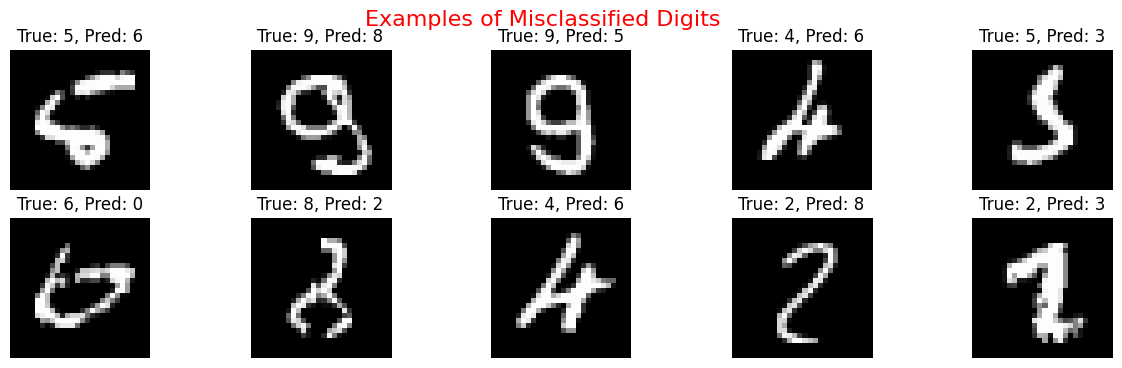

In [49]:
wrong_idx = np.where(y_pred != y_test)[0]
console.print(f"[red]Total Misclassified Samples: {len(wrong_idx)}")

n_show = 10
plt.figure(figsize=(15,4))
for i, idx in enumerate(wrong_idx[:n_show]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis("off")
plt.suptitle("Examples of Misclassified Digits", fontsize=16, color="red")
plt.show()

In [50]:
model_dir = "/content/drive/MyDrive/Codveda Technologies/models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "NN_MNIST.h5")
model.save(model_path)
console.print(f"[green]💾 Neural Network saved at: {model_path}")

💾 Neural Network saved at: /content/drive/MyDrive/Codveda Technologies/models/NN_MNIST.h5